In [2]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores

/home/jbelk/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Found 19 grids
Found 19 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
64 of 361 ligand, structure pairs failed to dock.
Loading rmsds...
All ligands successfully fingerprinted. Nice!


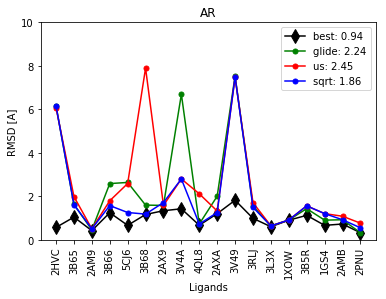

Found 11 grids
Found 11 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
All ligands and structures successfully docked. Nice!
Loading rmsds...
All ligands successfully fingerprinted. Nice!


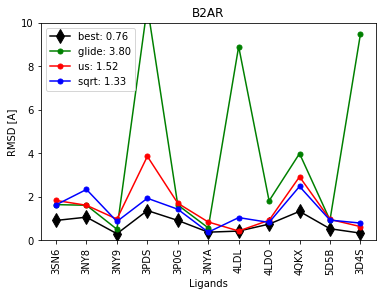

Found 17 grids
Found 17 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
All ligands and structures successfully docked. Nice!
Loading rmsds...
All ligands successfully fingerprinted. Nice!


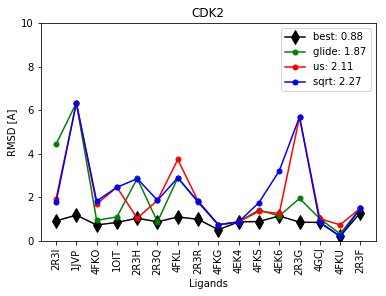

Found 8 grids
Found 8 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
All ligands and structures successfully docked. Nice!
Loading rmsds...
All ligands successfully fingerprinted. Nice!


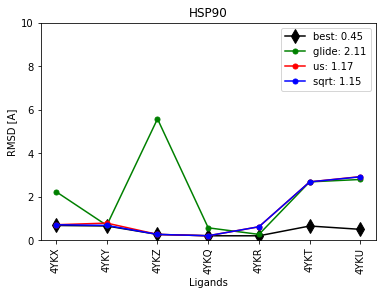

Found 5 grids
Found 5 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
All ligands and structures successfully docked. Nice!
Loading rmsds...
All ligands successfully fingerprinted. Nice!


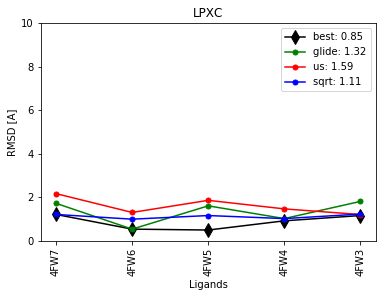

Found 35 grids
Found 35 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
107 of 1225 ligand, structure pairs failed to dock.
Loading rmsds...
All ligands successfully fingerprinted. Nice!


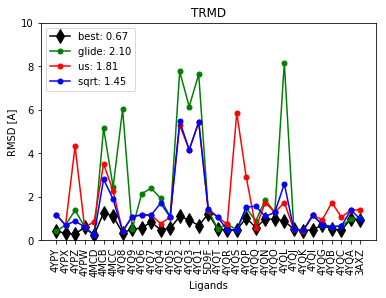

Found 13 grids
Found 13 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
All ligands and structures successfully docked. Nice!
Loading rmsds...
All ligands successfully fingerprinted. Nice!


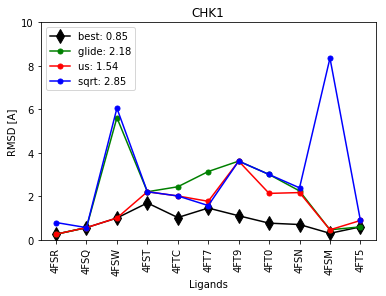

In [ ]:
get_ipython().magic(u'matplotlib inline')
datasets = ['AR', 'B2AR', 'CDK2','HSP90','LPXC','TRMD', 'CHK1']

def o(x,y):
    if x*y > 0: return (x*y)**0.5
    return -(-x*y)**0.5

for receptor in datasets:

    data_set_dir = '/scratch/PI/rondror/docking_data/'+receptor+'/'
   
    rmsd_file = 'rmsd.csv'
    ligands_dir = data_set_dir + 'ligands/'
    grids_dir = data_set_dir + 'grids/'
    glide_dir = data_set_dir + 'glide/'
    crystal_fp_file = data_set_dir + 'crystal_ifp_july5/ifp.fp'
    docking_fp_dir = data_set_dir + 'glide_ifp_july5/'

    #crystal_fp_file2 = data_set_dir + 'crystal_ifp_july5/ifp.fp'
    #docking_fp_dir2 = data_set_dir + 'glide_ifp_july5/'
    
    (crystals, glides) = load_data(
        data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file, docking_fp_dir)

    #(crystals2, glides2) = load_data(
    #    data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file, docking_fp_dir)
    
    max_num_poses = 50
    best_rmsd_matrix = best_pose(glides, max_num_poses)
    
    rmsd_filter = lambda x: x < 2
    best_structure, filtered_ligands, ave_rmsd = get_structure_and_ligands(best_rmsd_matrix, rmsd_filter, glides.keys())
    
    scores = Scores(glides, crystals, filtered_ligands, best_structure, max_num_poses)
    scores2 = Scores(glides, crystals, filtered_ligands, best_structure, max_num_poses, overlap=o)
    
    final_rmsds = plot_final_rmsds(scores,receptor,scores2,'sqrt: ')